In [5]:
# 1.读取数据
import glob
import pandas as pd
import json

# 匹配所有 train_plan_0*.csv
files = glob.glob("../data/train_plan_*.csv")
print("找到的文件:", files)

# 读入并合并
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

print("总数据行数:", len(df))
print("df:\n", df.head())

#获取json字符串
plans_json = df['json']
print("plans_json:\n", plans_json.iloc[0])

#字符串转json
plans_dict = []
ExecutionTimes = []
idx = 0
for json_str in plans_json:
    idx += 1
    plan_dict = json.loads(json_str)
    plans_dict.append(plan_dict['Plan'])
    try:
        ExecutionTimes.append(plan_dict['Execution Time'])
    except:
        print(f"idx: {idx} 不存在Execution Time")
        print(plan_dict)
print("plans_dict:\n", plans_dict[0])



找到的文件: ['../data/train_plan_part17.csv', '../data/train_plan_part8.csv', '../data/train_plan_part6.csv', '../data/train_plan_part3.csv', '../data/train_plan_part19.csv', '../data/train_plan_part9.csv', '../data/train_plan_part11.csv', '../data/train_plan_part1.csv', '../data/train_plan_part0.csv', '../data/train_plan_part18.csv', '../data/train_plan_part10.csv', '../data/train_plan_part12.csv', '../data/train_plan_part16.csv', '../data/train_plan_part15.csv', '../data/train_plan_part2.csv', '../data/train_plan_part14.csv', '../data/train_plan_part5.csv', '../data/train_plan_part7.csv', '../data/train_plan_part13.csv', '../data/train_plan_part4.csv']
总数据行数: 100000
df:
       id                                               json
0  85000  {"Plan": {"Node Type": "Bitmap Heap Scan", "Pa...
1  85001  {"Plan": {"Node Type": "Gather", "Parallel Awa...
2  85002  {"Plan": {"Node Type": "Hash Join", "Parallel ...
3  85003  {"Plan": {"Node Type": "Gather", "Parallel Awa...
4  85004  {"Plan": {"No

In [6]:
# 2.数据格式转换 json -> PlanNode
import sys, os
sys.path.append(os.path.abspath(".."))  # 确保当前目录加入路径

# json -> PlanNode
from models.DataPreprocessor import PlanNode, DataPreprocessor
preprocessor = DataPreprocessor()
plans_tree = preprocessor.preprocess_all(plans_dict)

In [20]:
# 3.数据格式转换 planNode -> graph 格式
# PlanNode -> edges_list, extra_info_list
def tree_to_graph(root):
    edges_list, extra_info_list = [], []

    def dfs(node, parent_idx):
        idx = len(extra_info_list)
        extra_info_list.append(node.extra_info)
        edges_list.append((idx, idx))
        if parent_idx is not None:
            edges_list.append((parent_idx, idx))
        for ch in node.children:
            dfs(ch, idx)

    dfs(root, None)
    return edges_list, extra_info_list

edges_list, matrix_plans = [], []
for i in plans_tree:
    edges_matrix, extra_info_matrix = tree_to_graph(i)
    # if len(edges_matrix) == 0:
    #     print(i)
    #     assert False
    edges_list.append(edges_matrix)
    matrix_plans.append(extra_info_matrix)

print(matrix_plans[0][0])
print(matrix_plans[0][1])



{'Node Type': 'Bitmap Heap Scan', 'Parallel Aware': False, 'Relation Name': 'movie_keyword', 'Alias': 'mk', 'Startup Cost': 11788.77, 'Total Cost': 49094.94, 'Plan Rows': 1028173, 'Plan Width': 12, 'Actual Startup Time': 41.924, 'Actual Total Time': 200.35, 'Actual Rows': 1029758, 'Actual Loops': 1, 'Recheck Cond': '(keyword_id > 17243)', 'Rows Removed by Index Recheck': 0, 'Exact Heap Blocks': 24037, 'Lossy Heap Blocks': 0}
{'Node Type': 'Bitmap Index Scan', 'Parent Relationship': 'Outer', 'Parallel Aware': False, 'Index Name': 'keyword_id_movie_keyword', 'Startup Cost': 0.0, 'Total Cost': 11531.73, 'Plan Rows': 1028173, 'Plan Width': 0, 'Actual Startup Time': 39.572, 'Actual Total Time': 39.572, 'Actual Rows': 1029758, 'Actual Loops': 1, 'Index Cond': '(keyword_id > 17243)'}


In [8]:
# 统计信息

from models.Utils import StatisticsInfo

statisticsInfo = StatisticsInfo(matrix_plans, sample_threshold=100, sample_k=10).build()
statisticsInfo.pretty_print_report()

# 全局信息



[Node Types] 13: ['Bitmap Heap Scan', 'Bitmap Index Scan', 'BitmapAnd', 'Gather', 'Gather Merge', 'Hash', 'Hash Join', 'Index Scan', 'Materialize', 'Merge Join', 'Nested Loop', 'Seq Scan', 'Sort']

[Global MUST keys] 10: ['Actual Loops', 'Actual Rows', 'Actual Startup Time', 'Actual Total Time', 'Node Type', 'Parallel Aware', 'Plan Rows', 'Plan Width', 'Startup Cost', 'Total Cost']

[Global ALL keys] 41: ['Actual Loops', 'Actual Rows', 'Actual Startup Time', 'Actual Total Time', 'Alias', 'Exact Heap Blocks', 'Filter', 'Hash Batches', 'Hash Buckets', 'Hash Cond', 'Index Cond', 'Index Name', 'Inner Unique', 'Join Filter', 'Join Type', 'Lossy Heap Blocks', 'Merge Cond', 'Node Type', 'Original Hash Batches', 'Original Hash Buckets', 'Parallel Aware', 'Parent Relationship', 'Peak Memory Usage', 'Plan Rows', 'Plan Width', 'Recheck Cond', 'Relation Name', 'Rows Removed by Filter', 'Rows Removed by Index Recheck', 'Rows Removed by Join Filter', 'Scan Direction', 'Single Copy', 'Sort Key', 'Sor

In [21]:
# NodeVectorizer (plan-only; no posterior 'Actual*' usage)
import re, math
import numpy as np
from typing import List

from models.Utils import process_join_cond_field, process_index_cond_field, load_column_stats

# -------- 配置 --------
NodeTypeVocab = [
    'Bitmap Heap Scan', 'Bitmap Index Scan', 'BitmapAnd', 'Gather', 'Gather Merge',
    'Hash', 'Hash Join', 'Index Scan', 'Materialize', 'Merge Join', 'Nested Loop',
    'Seq Scan', 'Sort'
]

# 公共区 = 13(onehot) + 5(plan 数值) = 18
PUBLIC_DIM = 18
# 每类型块大小（第0位是块mask）
BLOCK_K = 16
TOTAL_DIM = PUBLIC_DIM + len(NodeTypeVocab) * BLOCK_K

# 公共数值键（计划期）
GLOBAL_NUM_KEYS = [
    'Parallel Aware', 'Plan Rows', 'Plan Width', 'Startup Cost', 'Total Cost'
]

# 计划期归一化配置
LOG_KEYS = {'Plan Rows', 'Startup Cost', 'Total Cost'}
# 不log
NO_LOG_KEYS = {'Parallel Aware', 'Plan Width'}

PARENT_REL_VALS = ['Outer', 'Inner', 'Member']
JOIN_TYPE_VALS  = ['Inner', 'Left', 'Right', 'Full']
SCAN_DIR_VALS   = ['Forward', 'Backward']

# -------- 工具 --------
def _as_bool01(x):
    if isinstance(x, bool): return 1.0 if x else 0.0
    if x in (1, '1', 'true', 'True', 'TRUE', 't', 'T', 'yes', 'Yes'): return 1.0
    return 0.0

def _one_hot(value, vocab):
    v = [0.0] * len(vocab)
    try:
        idx = vocab.index(value)
        v[idx] = 1.0
    except Exception:
        pass
    return v

def embed_text(s: str, dim: int = 4, seed: int = 17):
    if s is None: s = ''
    out = []
    for i in range(dim):
        h = hash((seed + i, s))
        out.append(((h & 0xffffffff) / 0xffffffff))
    return out

def encode_condition(cond: str, dim: int = 8, is_join: bool = False):
    vec = []
    try:
        v = process_join_cond_field(cond) if is_join else process_index_cond_field(cond)
        if isinstance(v, (list, tuple)): vec = list(map(float, v))
    except Exception:
        ops = ['=', '>=', '<=', '>', '<', '<>']
        hot = [0.0]*len(ops)
        if cond:
            for i,op in enumerate(ops):
                if op in cond: hot[i] = 1.0; break
        nums = [float(x) for x in re.findall(r'[-+]?\d+(?:\.\d+)?', cond or '')][:2]
        while len(nums) < 2: nums.append(0.0)
        cols = re.findall(r'[A-Za-z_][A-Za-z_0-9]*\.[A-Za-z_][A-Za-z_0-9]*', cond or '')[:2]
        col_emb = []
        for c in cols: col_emb += embed_text(c, dim=2)
        while len(col_emb) < 4: col_emb.append(0.0)
        vec = hot + nums + col_emb
    if len(vec) >= dim: return vec[:dim]
    return vec + [0.0]*(dim - len(vec))

_COLUMN_STATS = None
def _load_stats_once():
    global _COLUMN_STATS
    if _COLUMN_STATS is None:
        try:
            _COLUMN_STATS = load_column_stats()  # 可给 plan 字段的 mean/std
        except Exception:
            _COLUMN_STATS = {}

def norm_value(x, key: str):
    _load_stats_once()
    if x is None: return 0.0
    try: xv = float(x)
    except Exception: return 0.0
    if key in LOG_KEYS: xv = math.log1p(max(xv, 0.0))
    st = _COLUMN_STATS.get(key)
    if st:
        mu = float(st.get("mean", 0.0)); sd = float(st.get("std", 0.0))
        if sd and sd > 1e-12: xv = (xv - mu) / sd
    return float(xv)

def write_vals(vec, start_idx, vals):
    idx = start_idx
    L = len(vec)
    for v in vals:
        if idx >= L: break
        vec[idx] = float(v); idx += 1
    return idx

# -------- 分类型块（计划期键）--------
def encode_block(node: dict, nodetype: str):
    b = [0.0] * BLOCK_K
    b[0] = 1.0
    wr = 1

    def parent_rel():
        return _one_hot(node.get('Parent Relationship'), PARENT_REL_VALS)

    if nodetype in ('Hash Join', 'Merge Join', 'Nested Loop'):
        wr = write_vals(b, wr, _one_hot(node.get('Join Type'), JOIN_TYPE_VALS))
        if nodetype == 'Hash Join':
            wr = write_vals(b, wr, encode_condition(node.get('Hash Cond'), dim=8, is_join=True))
        elif nodetype == 'Merge Join':
            wr = write_vals(b, wr, encode_condition(node.get('Merge Cond'), dim=8, is_join=True))
        else:  # Nested Loop
            wr = write_vals(b, wr, encode_condition(node.get('Join Filter'), dim=8, is_join=True))
        wr = write_vals(b, wr, parent_rel())

    elif nodetype in ('Index Scan', 'Bitmap Index Scan'):
        wr = write_vals(b, wr, embed_text(node.get('Index Name'), dim=4))
        wr = write_vals(b, wr, embed_text(node.get('Relation Name'), dim=4))
        wr = write_vals(b, wr, embed_text(node.get('Alias'), dim=2))
        wr = write_vals(b, wr, _one_hot(node.get('Scan Direction'), SCAN_DIR_VALS))
        wr = write_vals(b, wr, encode_condition(node.get('Index Cond'), dim=8, is_join=False))
        wr = write_vals(b, wr, parent_rel())

    elif nodetype == 'Seq Scan':
        wr = write_vals(b, wr, embed_text(node.get('Relation Name'), dim=4))
        wr = write_vals(b, wr, embed_text(node.get('Alias'), dim=2))
        wr = write_vals(b, wr, encode_condition(node.get('Filter'), dim=8, is_join=False))
        wr = write_vals(b, wr, parent_rel())

    elif nodetype == 'Sort':
        sort_key = node.get('Sort Key')
        keys = []
        if isinstance(sort_key, list):
            keys = sort_key
        elif isinstance(sort_key, str):
            m = re.findall(r'\"([^\"]+)\"', sort_key)
            keys = m if m else [sort_key] if sort_key else []
        if keys:
            acc = np.zeros(4, dtype=float)
            for k in keys[:4]:
                acc += np.array(embed_text(k, dim=4))
            acc = (acc / max(len(keys), 1)).tolist()
        else:
            acc = [0.0]*4
        wr = write_vals(b, wr, acc)
        wr = write_vals(b, wr, [ float(len(keys)) ])
        wr = write_vals(b, wr, parent_rel())

    elif nodetype in ('Gather', 'Gather Merge'):
        wr = write_vals(b, wr, [ norm_value(node.get('Workers Planned'), 'Workers Planned') ])
        if nodetype == 'Gather':
            wr = write_vals(b, wr, [ 1.0 if node.get('Single Copy') else 0.0 ])
        wr = write_vals(b, wr, parent_rel())

    elif nodetype == 'Bitmap Heap Scan':
        wr = write_vals(b, wr, embed_text(node.get('Relation Name'), dim=4))
        wr = write_vals(b, wr, encode_condition(node.get('Recheck Cond'), dim=8, is_join=False))
        wr = write_vals(b, wr, parent_rel())

    elif nodetype in ('Materialize', 'BitmapAnd', 'Hash'):
        # 这些在计划期能稳定拿到的关键信息有限；只保留 Parent Relationship
        wr = write_vals(b, wr, parent_rel())

    else:
        pass

    return b

# -------- 主函数 --------
def NodeVectorizer(matrix_plans: List[List[dict]]) -> List[List[List[float]]]:
    """
    计划期编码（无后验）：TOTAL_DIM = 18 + 13*16 = 226
      [0:13)   NodeType one-hot
      [13:18)  plan-only 数值: [Parallel Aware, Plan Rows, Plan Width, Startup Cost, Total Cost]
      [18:.. ) 13 个类型块（每块16，第0位为块mask=1）
    """
    res = []
    for mp in matrix_plans:
        plan_matrix = []
        for node in mp:
            vec = [0.0] * TOTAL_DIM

            # 1) NodeType
            try:
                node_type_idx = NodeTypeVocab.index(node["Node Type"])
            except Exception:
                print("Unknown Node Type:", node.get("Node Type"), "node:", node)
                assert False
            vec[node_type_idx] = 1.0

            # 2) 公共 plan 数值
            p = 13
            for k in GLOBAL_NUM_KEYS:
                if k == 'Parallel Aware':
                    v = _as_bool01(node.get(k))
                else:
                    v = norm_value(node.get(k), k)
                vec[p] = float(v); p += 1
            # p == 18

            # 3) 类型块（仅写本类型）
            block_base = PUBLIC_DIM + node_type_idx * BLOCK_K
            bvec = encode_block(node, NodeTypeVocab[node_type_idx])
            for i in range(BLOCK_K):
                vec[block_base + i] = bvec[i]

            plan_matrix.append(vec)
        res.append(plan_matrix)
    return res

res = NodeVectorizer(matrix_plans)



[[1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  13.843294971374661,
  12.0,
  9.374987485283455,
  10.8015316219727,
  1.0,
  0.7867672040096407,
  0.29929942202272347,
  0.7210544535706412,
  0.6428094850021436,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  17243.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0

In [30]:
print(len(res[0]))
print(len(res[0][0]))
print(len(res[0][1]))

2
226
226


In [ ]:
# 模型搭建

import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch

class NodeEncoder(nn.Module):
    """
    输入: data.x 形状 [N, F_in]
    输出: node_embs [N, d_node]
    """
    def __init__(self, in_dim: int, d_node: int):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, d_node),
            nn.ReLU(),
            nn.LayerNorm(d_node),
        )
    def forward(self, x):
        return self.proj(x)

# ---- 组合总模型 ----
class PlanCostModel(nn.Module):
    """
    NodeEncoder → GATTreeEncoder → PredictionHead
    """
    def __init__(self, nodecoder: nn.Module, treeencoder: nn.Module, predict_head: nn.Module):
        super().__init__()
        self.nodecoder = nodecoder
        self.treeencoder = treeencoder
        self.predict_head = predict_head

    def forward(self, data: Data | Batch):
        """
        期望 data 里至少有:
        - x: [N, F_in]
        - edge_index: [2, E]
        - batch: [N]  指示每个节点属于哪张图
        """
        x = self.nodecoder(data.x)                                   # [N, d_node]
        g = self.treeencoder(x, data.edge_index, data.batch)         # [B, d_graph]
        y = self.predict_head(g)                                     # [B, out_dim]
        return y


from models.TreeEncoder import GATTreeEncoder
from models.PredictionHead import PredictionHead
# ---- 使用示例 ----
# 假设你的节点原始特征维度 F_in=64，节点隐层 d_node=128，图级维度 d_graph=256
F_in, d_node, d_graph = 226, 32, 64
nodecoder = NodeEncoder(F_in, d_node)
gatTreeEncoder = GATTreeEncoder(
    input_dim=d_node,      # 一定用实际特征维度
    hidden_dim=64,
    output_dim=d_graph,
    num_layers=3,
    num_heads=4,
    dropout=0.1,
    pooling="mean"
)
predict_head = PredictionHead(d_graph, out_dim=1)
model = PlanCostModel(nodecoder, gatTreeEncoder, predict_head)


In [11]:
print(type(ExecutionTimes))
print(type(res))
print(type(edges_list))
print(model)


<class 'list'>
<class 'list'>
<class 'list'>
PlanCostModel(
  (nodecoder): NodeEncoder(
    (proj): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): ReLU()
      (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
  )
  (treeencoder): GATTreeEncoder(
    (convs): ModuleList(
      (0): GATConv(32, 64, heads=4)
      (1-2): 2 x GATConv(256, 64, heads=4)
    )
    (norms): ModuleList(
      (0-2): 3 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (output_proj): Linear(in_features=256, out_features=64, bias=True)
  )
  (predict_head): PredictionHead(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


In [12]:
# 4.构建数据集class
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

def coerce_x_to_tensor(x_plan, in_dim: int):
    """
    x_plan: 很深的 list（最终行向量长度= in_dim）
    变成 [N, in_dim] 的 float32 Tensor
    """
    x = torch.tensor(x_plan, dtype=torch.float32)
    assert x.numel() % in_dim == 0, f"最后一维应为 {in_dim}，拿到形状 {tuple(x.shape)}"
    x = x.view(-1, in_dim)   # 拉平成 [N, in_dim]
    return x

def coerce_edge_index(ei_like):
    """
    ei_like: list/ndarray/tensor, 形状 [2,E] 或 [E,2]
    返回规范 [2,E] 的 long Tensor
    """
    ei = torch.as_tensor(ei_like, dtype=torch.long)
    if ei.ndim != 2:
        raise ValueError(f"edge_index 需要二维，拿到 {tuple(ei.shape)}")
    if ei.shape[0] != 2 and ei.shape[1] == 2:
        ei = ei.t().contiguous()
    elif ei.shape[0] != 2 and ei.shape[1] != 2:
        raise ValueError(f"edge_index 需为 [2,E] 或 [E,2]，拿到 {tuple(ei.shape)}")
    return ei.contiguous()

def build_dataset(res, edges_list, execution_times, in_dim=16, bidirectional=False):
    assert len(res) == len(edges_list) == len(execution_times), "长度必须一致"
    data_list = []
    for i, (x_plan, ei_like, y) in enumerate(zip(res, edges_list, execution_times)):
        x = coerce_x_to_tensor(x_plan, in_dim)      # [N, in_dim]
        edge_index = coerce_edge_index(ei_like)     # [2,E]
        N = x.size(0)

        # 边索引有效性检查
        if edge_index.numel() > 0:
            if int(edge_index.min()) < 0 or int(edge_index.max()) >= N:
                raise ValueError(f"plan[{i}] 的 edge_index 越界：节点数 N={N}，但 edge_index.max={int(edge_index.max())}")

        # 可选：做成双向图（若你的 edges 只有父->子）
        if bidirectional:
            edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

        y = torch.tensor([float(y)], dtype=torch.float32)  # 图级回归标签
        data_list.append(Data(x=x, edge_index=edge_index, y=y))
    return data_list


In [13]:
# 构建数据集
dataset = build_dataset(res, edges_list, ExecutionTimes, in_dim=F_in, bidirectional=True)
print(f"数据集大小: {len(dataset)}")
print(f"第一个样本: x.shape={dataset[0].x.shape}, edge_index.shape={dataset[0].edge_index.shape}, y={dataset[0].y}")



数据集大小: 100000
第一个样本: x.shape=torch.Size([2, 16]), edge_index.shape=torch.Size([2, 6]), y=tensor([224.4540])


In [14]:
# 5. 训练准备
from sklearn.model_selection import train_test_split
import time
import os

# 数据集划分
train_indices, temp_indices = train_test_split(
    range(len(dataset)), test_size=0.3, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, random_state=42
)

train_dataset = [dataset[i] for i in train_indices]
val_dataset = [dataset[i] for i in val_indices]
test_dataset = [dataset[i] for i in test_indices]

print(f"训练集: {len(train_dataset)}, 验证集: {len(val_dataset)}, 测试集: {len(test_dataset)}")

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"训练批次数: {len(train_loader)}, 验证批次数: {len(val_loader)}")



训练集: 70000, 验证集: 15000, 测试集: 15000
训练批次数: 2188, 验证批次数: 469


In [15]:
# 6. 训练配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
criterion = torch.nn.MSELoss()

# 早停机制
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

early_stopping = EarlyStopping(patience=15, min_delta=0.001)


使用设备: cuda


In [16]:
import torch
print(torch.__version__)
print(torch.version.cuda)   # None 就表示没有 CUDA


2.5.1+cu121
12.1


In [17]:

# 7. 训练函数
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # 前向传播
        pred = model(batch)
        loss = criterion(pred, batch.y)
        
        # 反向传播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    q_errors = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = criterion(pred, batch.y)
            total_loss += loss.item()
            num_batches += 1
            q_error = torch.maximum(pred / batch.y, batch.y / pred)
            q_errors.append(q_error.mean().item())
    print(f"Q-error: {np.mean(q_errors):.6f}")

    return total_loss / num_batches


In [18]:

# 8. 训练循环
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, 
                early_stopping, device, num_epochs=100):
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    print("开始训练...")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # 训练
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # 验证
        val_loss = validate_epoch(model, val_loader, criterion, device)
        
        # 学习率调度
        scheduler.step(val_loss)
        
        # 记录损失
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # 计算时间
        epoch_time = time.time() - start_time
        
        # 打印进度
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1:3d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
                  f"Time: {epoch_time:.2f}s")
        
        # 早停检查
        if early_stopping(val_loss, model):
            print(f"\n早停触发在第 {epoch+1} 轮")
            break
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, '../models/best_model.pth')
    
    print("-" * 60)
    print("训练完成!")
    print(f"最佳验证损失: {best_val_loss:.6f}")
    
    return train_losses, val_losses

# 开始训练
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer, scheduler, 
    criterion, early_stopping, device, num_epochs=100
)


开始训练...
------------------------------------------------------------
Q-error: 61.367081
Epoch   1/100 | Train Loss: 148767426.063528 | Val Loss: 139323203.264392 | LR: 1.00e-03 | Time: 25.90s
Q-error: 188.992151
Q-error: 109.037056
Q-error: 81.669301
Q-error: 206.620935
Q-error: 333.894261
Epoch   6/100 | Train Loss: 129681403.179616 | Val Loss: 171770202.038646 | LR: 1.00e-03 | Time: 33.47s
Q-error: 758.501874
Q-error: 53.194063
Q-error: 169.636366
Q-error: 61.763253
Q-error: 38.240612
Epoch  11/100 | Train Loss: 134289651.557073 | Val Loss: 155180844.595416 | LR: 1.00e-03 | Time: 29.44s
Q-error: 147.629705
Q-error: 54.302326
Q-error: 106.317776
Q-error: 25.399068
Q-error: 158.566361
Epoch  16/100 | Train Loss: 140402541.153108 | Val Loss: 143125283.277185 | LR: 1.00e-03 | Time: 30.50s
Q-error: 59.697670
Q-error: 379.520713
Q-error: 132.325790
Q-error: 62.724867
Q-error: 68.618767
Epoch  21/100 | Train Loss: 135811075.844264 | Val Loss: 164324525.857942 | LR: 1.00e-03 | Time: 27.18s


KeyboardInterrupt: 

已加载最佳模型进行测试


/tmp/ipykernel_2930827/3599755249.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../models/best_model.pth', map_location=device)



测试集评估结果:
MSE:  131052432.000000
RMSE: 11447.813477
MAE:  4966.923828
相对误差: 6.257197


/tmp/ipykernel_2930827/3599755249.py:74: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2930827/3599755249.py:74: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2930827/3599755249.py:74: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2930827/3599755249.py:74: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2930827/3599755249.py:74: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2930827/3599755249.py:74: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2930827/3599755249.py:74: UserWarning: Glyph 22833 (\N{CJK UN

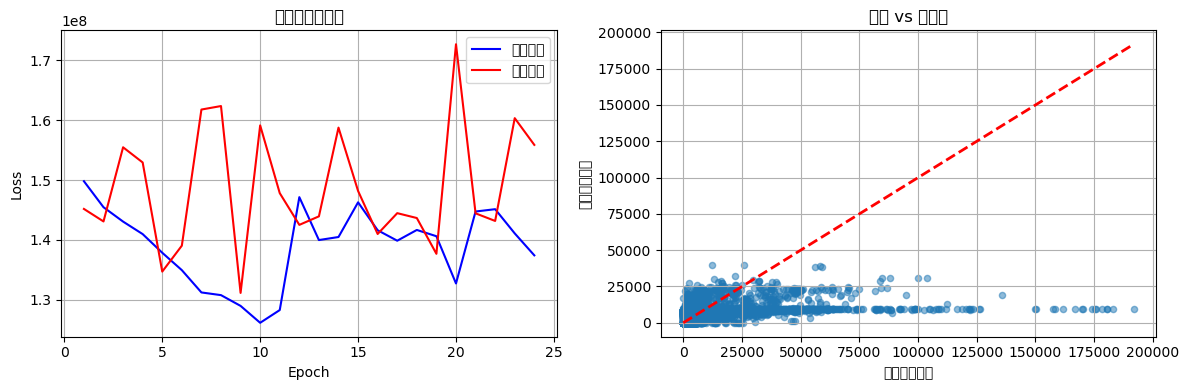

In [ ]:

# 9. 测试评估
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch)
            predictions.extend(pred.cpu().numpy())
            targets.extend(batch.y.cpu().numpy())
    
    predictions = np.array(predictions)
    targets = np.array(targets)
    
    # 计算评估指标
    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - targets))
    
    # 计算相对误差
    relative_error = np.mean(np.abs((predictions - targets) / (targets + 1e-8)))
    
    print("\n" + "="*50)
    print("测试集评估结果:")
    print("="*50)
    print(f"MSE:  {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE:  {mae:.6f}")
    print(f"相对误差: {relative_error:.6f}")
    print("="*50)
    
    return predictions, targets, {'mse': mse, 'rmse': rmse, 'mae': mae, 'relative_error': relative_error}

# 加载最佳模型进行测试
try:
    checkpoint = torch.load('../models/best_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("已加载最佳模型进行测试")
except FileNotFoundError:
    print("未找到保存的模型，使用当前模型进行测试")

predictions, targets, metrics = evaluate_model(model, test_loader, device)

# 10. 可视化训练过程和结果
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(12, 4))
    
    # 训练损失曲线
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='训练损失')
    plt.plot(epochs, val_losses, 'r-', label='验证损失')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('训练和验证损失')
    plt.legend()
    plt.grid(True)
    
    # 预测 vs 真实值
    plt.subplot(1, 2, 2)
    plt.scatter(targets, predictions, alpha=0.5, s=20)
    min_val = min(targets.min(), predictions.min())
    max_val = max(targets.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('真实执行时间')
    plt.ylabel('预测执行时间')
    plt.title('预测 vs 真实值')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('../results/training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# 创建结果目录
os.makedirs('../results', exist_ok=True)
os.makedirs('../models', exist_ok=True)

# 绘制结果
plot_training_history(train_losses, val_losses)


In [ ]:

# 11. 模型保存和加载工具函数
def save_model_with_metadata(model, filepath, metadata=None):
    """保存模型和相关元数据"""
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_config': {
            'F_in': F_in,
            'd_node': d_node,
            'd_graph': d_graph,
        },
        'training_metadata': metadata or {}
    }
    torch.save(save_dict, filepath)
    print(f"模型已保存到: {filepath}")

def load_model_with_metadata(filepath, model_class, device='cpu'):
    """加载模型和元数据"""
    checkpoint = torch.load(filepath, map_location=device)
    
    # 重建模型
    config = checkpoint['model_config']
    nodecoder = NodeEncoder(config['F_in'], config['d_node'])
    gatTreeEncoder = GATTreeEncoder(
        input_dim=config['d_node'],
        hidden_dim=64,
        output_dim=config['d_graph'],
        num_layers=3,
        num_heads=4,
        dropout=0.1,
        pooling="mean"
    )
    predict_head = PredictionHead(config['d_graph'], out_dim=1)
    model = PlanCostModel(nodecoder, gatTreeEncoder, predict_head)
    
    # 加载权重
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    return model, checkpoint.get('training_metadata', {})

# 保存最终模型
final_metadata = {
    'train_size': len(train_dataset),
    'val_size': len(val_dataset),
    'test_size': len(test_dataset),
    'final_metrics': metrics,
    'training_epochs': len(train_losses)
}

save_model_with_metadata(model, '../models/final_model.pth', final_metadata)

print("\n训练完成! 模型已保存，结果已可视化。")


模型已保存到: ../models/final_model.pth

训练完成! 模型已保存，结果已可视化。
